# PROJET 5 : Catégorisez automatiquement les questions 

**PLAN DE PROJET**
1. Titre de projet : PROJET 5 - Catégorisez automatiquement les questions


2. Chargement de bibliothèques


3. Récupérer les données + Séparation de données en test et train
    - Enregistrement de fichiers en .csv :
        - X_train.csv
        - y_train.csv
        - X_test.csv
        - y_test.csv


4. Data cleaning
    - Features :
        - Enlever les balises HTML
        - Enlever la ponctuation
        - Mise en minuscule et tokenization
        - Enlever les stopwords
    - Target :
        - Enlever les balises "<>"


5. Feature engineering 
    - Recodage en bigrams
    - Fusion de title, body + bigrams


6. Analyse exploratoire
    - Analyses univariées
        - Description générale : Longueur de posts, nombre de tags
        - Bag of words : Les expressions les plus fréquentes : feature & target
            - Arrays générées:
                - X_train_bow
                - X_train_vocab_bow
                - X_train_dist_bow
                - y_train_bow
                - y_train_vocab_bow
                - y_train_dist_bow
                
                
        - TF - IDF : Les expressions les plus fréquentes : feature & target
             - Arrays générées:
                  - X_train_ifidf
                  - X_train_vocab_ifidf
                  - X_train_dist_ifidf
                  - y_train_ifidf
                  - y_train_vocab_ifidf
                  - y_train_dist_ifidf
                  

    - Analyse multivarié 
    **QUESTION : Peut-on considérer LDA comme analyse multivariée ?**
    
    
    - Réduction de dimensions
    **QUESTION : Peut-on faire un word2vec ?**
    
    
        

# Chargement de bibliothéques

In [1]:
# Import the libraries
import joblib
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import nltk
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
import re

# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup 

# Libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
#Disable warning for .loc
pd.options.mode.chained_assignment = None  # default='warn'

# Récupération de données

## Loader les fichiers .csv

In [3]:
# Load the .csv files
X_train = pd.read_csv('Data/X_train.csv', sep='\t')
X_test = pd.read_csv('Data/X_test.csv', sep='\t')
y_train = pd.read_csv('Data/y_train.csv', sep='\t')
y_test = pd.read_csv('Data/y_test.csv', sep='\t')

In [4]:
# Check the loaded files
print ("Le jeu de données X_train contient", X_train.shape[0], "observations et", X_train.shape[1], "features.") 
print ("Le vecteur y_train contient", y_train.shape[0], "observations.") 
print ("Le jeu de données X_test contient", X_test.shape[0], "observations et", X_test.shape[1], "features.") 
print ("Le vecteur y_test contient", y_test.shape[0], "observations.")  

Le jeu de données X_train contient 9843 observations et 3 features.
Le vecteur y_train contient 9842 observations.
Le jeu de données X_test contient 9844 observations et 3 features.
Le vecteur y_test contient 9843 observations.


## Récupérer les arrays

### Bag of words

In [5]:
# Load the arrays 
X_train_bow = np.load('Data/X_train_bow.npy')
X_train_vocab_bow = np.load('Data/X_train_vocab_bow.npy')
X_train_dist_bow = np.load('Data/X_train_dist_bow.npy')
y_train_bow = np.load('Data/y_train_bow.npy')
y_train_vocab_bow = np.load('Data/y_train_vocab_bow.npy')
y_train_dist_bow = np.load('Data/y_train_dist_bow.npy')
X_train_title_bow = np.load('Data/X_train_title_bow.npy')
X_train_title_vocab_bow = np.load('Data/X_train_title_vocab_bow.npy')
X_train_title_dist_bow = np.load('Data/X_train_title_dist_bow.npy')

### TF-IDF

In [6]:
# Load the arrays 
X_train_tfidf = np.load('Data/X_train_tfidf.npy')
X_train_vocab_tfidf = np.load('Data/X_train_vocab_tfidf.npy')
X_train_dist_tfidf = np.load('Data/X_train_dist_tfidf.npy')
y_train_tfidf = np.load('Data/y_train_tfidf.npy')
y_train_vocab_tfidf = np.load('Data/y_train_vocab_tfidf.npy')
y_train_dist_tfidf = np.load('Data/y_train_dist_tfidf.npy')
X_train_title_tfidf = np.load('Data/X_train_title_tfidf.npy')
X_train_title_vocab_tfidf = np.load('Data/X_train_title_vocab_tfidf.npy')
X_train_title_dist_tfidf = np.load('Data/X_train_title_dist_tfidf.npy')

# Modélisation de flags basée sur les fréquences

## Fréquences BOW

Nous allons mettre en oeuvre une méthode basée uniquement sur les fréquences des expressions (mot / bigram) utilisées dans le post et nous allons regarder si les expressions les plus fréquentes apparaissent dans le vocabulaire de tags.

Tout d'abord, nous allons analyser s'il existe un ou plusieurs expressions, présentes au moins deux fois dans chaque post, qui matchent avec le vocabulaire de tags. 

Nous allons utiliser la décomposition en Bag of words créé dans le notebook1, chapître 6.1.2 :

In [7]:
#The tags vocabulary :
y_train_vocab_bow[:10]

array(['.a', '.d.ts', '.htaccess', '.net', '.net-2.0', '.net-3.5',
       '.net-4.0', '.net-4.5', '.net-assembly', '.net-attributes'],
      dtype='<U31')

In [8]:
#The features vocabulary : 
X_train_vocab_bow[:10]

array(['##', '##-##', '#-#', '#-b', '#-bin', '#-branch', '#-change',
       '#-error', '#-modified', '#-new'], dtype='<U33')

In [9]:
#The BOW array :
X_train_bow[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Tester les fonctions sur le premier post

Nous allons tester notre idée sur le premier post.

In [10]:
BOW_post1 = X_train_bow[0]
BOW_post1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [11]:
#We print all expressions which are at least 2 times in the post :
for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        print (freq, word)

2 constructor
5 error
3 message


In [12]:
#We compare the frequent expression to the tag's vocab:

for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        if word in y_train_vocab_bow:
            print(word)

constructor
message


In [13]:
predicted_tags_vect = []

for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        if word in y_train_vocab_bow:
            predicted_tags_vect.append(word)

predicted_tags_vect

['constructor', 'message']

### Création d'une fonction à appliquer sur toutes les données

Maintenant, nous allons créer une fonction qui va sortir les tags pour chaque post :

In [14]:
def pred_tag_freq(BOW, vocabulary, list_of_tags):
    
    """Function which generates a list of tags, based on frequency of expression in a BOW object and 
    its comparison to predefined list of tags.
    
    Input :
    - BOW : a BOW array
    - vocabulary : list of BOW vocabulary
    - list_of_tags : a list of tags
    
    Output :
    - a list of predicted tags  
    
    """
    predicted_tags = []
    
    for vect in range(BOW.shape[0]): 
        
        predicted_tags_vect = [] 
        
        for freq, word in zip(BOW[vect], vocabulary):
            
            if freq >= 2:
                if word in list_of_tags:
                    predicted_tags_vect.append(word)
                    
        predicted_tags.append(predicted_tags_vect)
        
    return predicted_tags

In [15]:
predicted_tags = pred_tag_freq(X_train_bow, X_train_vocab_bow, y_train_vocab_bow)

In [16]:
len(predicted_tags)

9843

In [17]:
predicted_tags[:10]

[['constructor', 'message'],
 ['latitude-longitude'],
 ['android', 'crash'],
 ['exception', 'window'],
 ['feed', 'r'],
 ['cgi', 'difference', 'uri'],
 ['dependency-injection', 'function', 'interface', 'object', 'virtual'],
 ['ascii',
  'break',
  'c',
  'c++',
  'case',
  'char',
  'const',
  'count',
  'function',
  'github',
  'int',
  'integer',
  'letter',
  'malloc',
  'max',
  'min',
  'null',
  'printf',
  'return',
  'size',
  'sizeof',
  'stack',
  'store',
  'unsigned',
  'void'],
 ['max', 'mysql', 'set', 'size', 'varchar'],
 ['c',
  'csv',
  'dataframe',
  'import',
  'letter',
  'np',
  'numpy',
  'row',
  'split',
  'string',
  'transform',
  'var']]

Sauvegarder les tags prédits:

In [18]:
#Save the predicted tags:
np.save('Data/predicted_tags', predicted_tags)

Nous allons analyser le nombre de tag prédits par la méthode :

In [19]:
nbr_tags = []

for tag in range(len(predicted_tags)):
    length = len(predicted_tags[tag])
    nbr_tags.append(length)
    
nbr_tags = DataFrame(nbr_tags)

In [20]:
nbr_tags[0].value_counts()

2     1783
3     1742
4     1280
1     1182
5      897
6      623
0      479
7      408
8      326
9      233
10     157
11     134
12      91
13      71
14      66
15      63
16      43
17      35
19      32
18      31
20      30
23      18
21      17
25      16
22      15
26       7
24       6
31       5
29       5
32       5
28       4
30       4
34       3
47       3
42       3
27       3
51       2
38       2
40       2
48       2
35       2
41       2
39       2
43       1
33       1
58       1
76       1
37       1
45       1
74       1
46       1
67       1
Name: 0, dtype: int64

Désavantage de la méthode : nous avons des posts sans tag attribué (479 posts) et certains posts peuvent avoir un grand nombre de tags, même si c'est plutôt rare. Nous allons appliquer la même méthode avec TF-IDF et choisir 3 tags les plus fréquents basé sur le coefficient TF-IDF. 

## Fréquences TF-IDF

L'idée est d'utiliser les fréquences TF-IDF pour avoir la main sur le nombre de tags à prédire. Cette fois-ci, la méthode sera basé sur la procédure suivante :

1. Nous allons comparer toutes les expressions dans le post avec le vocabulaire de tags
2. Nous allons attribuer à chaque expression la distance relative TF-IDF de tag
3. Nous allons sortir 3 tags les plus fréquents

In [21]:
y_train_dist_tfidf[:10]

array([  0.57676875,   0.81346388,   5.41406727, 113.99212282,
         1.90929443,   5.74109131,   3.80868117,   4.5396082 ,
         0.58506653,   1.6894902 ])

### Tester les fonctions sur le premier post

In [22]:
#Extract the array of first post
TFIDF_post1 = X_train_tfidf[0]
TFIDF_post1

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
#We compare the expressions in the post to the tag's vocab:
for freq, word in zip(TFIDF_post1, X_train_vocab_tfidf):
    if freq > 0:
        if word in y_train_vocab_tfidf:
            print(word)

apply
console
constructor
function
javascript
message
prototype
subclass
var


In [24]:
#We list the common expressions which are in both document and the tag's vocabulary:

liste_tags = []

for freq, word in zip(TFIDF_post1, X_train_vocab_tfidf):
    if freq > 0:
        if word in y_train_vocab_tfidf:
            liste_tags.append(word)

In [25]:
liste_tags

['apply',
 'console',
 'constructor',
 'function',
 'javascript',
 'message',
 'prototype',
 'subclass',
 'var']

In [26]:
#We zip the list with tag's relative frequency:

for freq, word in zip(y_train_dist_tfidf, liste_tags):
    print(freq, word)

0.5767687452625023 apply
0.813463876986981 console
5.414067269547913 constructor
113.99212281549468 function
1.9092944332315822 javascript
5.741091311565432 message
3.808681173132807 prototype
4.539608202141523 subclass
0.5850665258062158 var


In [27]:
#Zip the tags contained in the post and tag's frequency
liste = zip(y_train_dist_tfidf, liste_tags)

In [28]:
#Converting to list
liste = list(liste)

In [29]:
#Check
liste

[(0.5767687452625023, 'apply'),
 (0.813463876986981, 'console'),
 (5.414067269547913, 'constructor'),
 (113.99212281549468, 'function'),
 (1.9092944332315822, 'javascript'),
 (5.741091311565432, 'message'),
 (3.808681173132807, 'prototype'),
 (4.539608202141523, 'subclass'),
 (0.5850665258062158, 'var')]

In [30]:
#Sort the list by frequency
liste_sort = sorted(liste, key = lambda x: x[0])

In [31]:
#Check
liste_sort

[(0.5767687452625023, 'apply'),
 (0.5850665258062158, 'var'),
 (0.813463876986981, 'console'),
 (1.9092944332315822, 'javascript'),
 (3.808681173132807, 'prototype'),
 (4.539608202141523, 'subclass'),
 (5.414067269547913, 'constructor'),
 (5.741091311565432, 'message'),
 (113.99212281549468, 'function')]

In [32]:
#Extract 3 most frequent tags 
tags_final = liste_sort[-3:]

In [33]:
tags_final

[(5.414067269547913, 'constructor'),
 (5.741091311565432, 'message'),
 (113.99212281549468, 'function')]

In [34]:
#Extract the tag's name
tags = [x[1] for x in tags_final]

In [35]:
tags

['constructor', 'message', 'function']

### Appliquer la fonctions sur toutes les données

Maintenant, nous allons créer une fonction qui va sortir les tags pour chaque post :

In [36]:
# At first, we will test the function on a sample
test_sample = X_train_tfidf[:100]

In [37]:
test_sample.shape

(100, 5000)

In [38]:
def pred_tag_tfidf(tfidf_array, tfidf_vocabulary, list_of_tags):
    
    """Function generatig a list of tags, based on frequency of expression in an TF-IDF object and 
    its comparison to predefined list of tags. 
    
    Is the document contains more than 3 common expressions with the list of tags, the tags are sorted by the 
    TF-IDF frequency and only 3 most common tags are the predicted tags. If the document contains 
    2 or less common expressions, all the expressions are considered comme predicted tags. 
        
    Input :
    - tfidf_array : a TF-IDF array
    - tfidf_vocabulary : a TF-IDF vocabulary object
    - list_of_tags : a vocabulary of tags
    
    Output :
    - a list of predicted tags  
    
    """
    predicted_tags = []
    
    for doc in range(tfidf_array.shape[0]): 
       
        #We list the common expressions which are in both document and the tag's vocabulary:   
    
        liste_tags = []

        for freq, word in zip(tfidf_array[doc], tfidf_vocabulary):
            if freq > 0:
                if word in list_of_tags:
                    liste_tags.append(word)
                    
            liste = list(zip(y_train_dist_tfidf, liste_tags))      
            
            #Sort the list by frequency
            liste_sort = sorted(liste, key = lambda x: x[0])
            
            #Choose only 3 most frequent expressions
            tags_final = liste_sort[-3:]
            
            #Extract the tag's name
            tags = [x[1] for x in tags_final]
                    
        predicted_tags.append(tags)
    
    return predicted_tags

In [39]:
# Fit the sample
liste = pred_tag_tfidf(test_sample, X_train_vocab_tfidf, y_train_vocab_tfidf)

In [40]:
# Check n#1
len(liste)

100

In [41]:
# Check n#2
liste[:10]

[['constructor', 'message', 'function'],
 ['latitude-longitude', 'size', 'window'],
 ['device', 'stack', 'get'],
 ['crash', 'function', 'database'],
 ['html', 'version', 'javascript'],
 ['cgi', 'difference', 'uri'],
 ['configuration', 'function', 'dependency-injection'],
 ['c++', 'merge', 'break'],
 ['mysql', 'size', 'row'],
 ['c', 'csv', 'comma']]

In [42]:
# Fit all the data
predicted_tags = pred_tag_tfidf(X_train_tfidf, X_train_vocab_tfidf, y_train_vocab_tfidf)

### Description de tags prédits

Nous allons regarder le nombre de tags par post :

In [43]:
nbr_tags = []

for tag in range(len(predicted_tags)):
    length = len(predicted_tags[tag])
    nbr_tags.append(length)
    
nbr_tags = DataFrame(nbr_tags)

In [44]:
nbr_tags[0].value_counts()

3    9228
2     435
1     145
0      35
Name: 0, dtype: int64

La plupart de posts ont 3 tags, tandis que seulement 35 posts n'ont aucun tag.

Combien d'expressions nous avons au total ? Pour répondre à la question, nous allons créer un vocabulaire de tags prédits avec bag of words.

In [45]:
# Format the lists to strings
" ".join(predicted_tags[0])

'constructor message function'

In [46]:
# Format the lists to strings

predicted_tags_str = []

for i in range(len(predicted_tags)):
    elt = " ".join(predicted_tags[i])
    predicted_tags_str.append(elt)

In [47]:
predicted_tags_str[:10]

['constructor message function',
 'latitude-longitude size window',
 'device stack get',
 'crash function database',
 'html version javascript',
 'cgi difference uri',
 'configuration function dependency-injection',
 'c++ merge break',
 'mysql size row',
 'c csv comma']

In [48]:
#Second execution after stop-words update
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 5000,
                             lowercase=False,
                             stop_words = None)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

predicted_tags_bow = vectorizer.fit_transform(predicted_tags_str)

Creating the bag of words...



In [49]:
predicted_tags_bow = predicted_tags_bow.toarray()

In [50]:
# Create a vocabulary of features
predicted_tags_vocab_bow = vectorizer.get_feature_names()

In [51]:
predicted_tags_vocab_bow[:10]

['abc',
 'abstract',
 'abstraction',
 'action',
 'adapter',
 'add',
 'address',
 'admin',
 'administrator',
 'aes']

In [52]:
len(predicted_tags_vocab_bow)

1064

Nous avons réduit le nombre de tags de ~5k à 1k.

Afficher les expressions les plus courantes:

In [53]:
# Sum up the counts of each vocabulary word
predicted_tags_dist_bow = np.sum(predicted_tags_bow, axis=0)

In [54]:
freq_tags_bow = DataFrame(zip(predicted_tags_vocab_bow, predicted_tags_dist_bow))
freq_tags_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_tags_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_tags_bow['Pourcentage'] = round(freq_tags_bow['Frequence']*100/sum(freq_tags_bow['Frequence']),2)
freq_tags_bow[:50]

,Word,Frequence,Pourcentage
359,get,904,3.07
313,file,800,2.72
350,function,553,1.88
224,difference,513,1.74
107,class,469,1.59
363,git,425,1.44
130,command,391,1.33
480,java,374,1.27
482,javascript,328,1.11
743,python,319,1.08


# Modélisation non supervisée

## LDA

In [55]:
print ("Number of unique tags: %d" % len(y_train_vocab_tfidf))

Number of unique tags: 4998


Nous allons faire LDA afin de trouver des sujets de posts. Etant donné que nous avons un grand nombre de tags uniques (~5k), nous allons réformuler les tags existants à l'aide de mots clés caractéristiques pour chaque sujet. 

Nous allons essayer de trouver un nombre de sujets optimal, pour que les sujets soient interprétables.

### Document = titre + body + bigrams

In [56]:
# First training of LDA : 20 topics
no_topics = 20

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_tfidf)

In [57]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

display_topics(lda, X_train_vocab_tfidf, no_top_words)

Topic 0
contentview jamie edittext textcolor keyboard delete simulator button textsize io
Topic 1
git branch commit repository master github remote push commits merge
Topic 2
compose docker-compose locale observable observer inspect exception-e docker yield container
Topic 3
permanently line-number eth name-attr attr-android retrieving-parent parent-item textappearance-material widget-material inverse
Topic 4
string function like difference code class value data object get
Topic 5
spring hidden-feature feature groupid window browser-window artifactid hidden sqlite div
Topic 6
hidden-feature hidden feature async await async-await thread-sleep #-modified #-use modified
Topic 7
recyclerview retina notepad++ lf cr america africa viewholder asia gmt+
Topic 8
td tr td-td td-tr var-var tr-td tr-tr e+-j j-e+ e+-+
Topic 9
sublime sublime-text text longer-text version-control text-string text-editor node lowercase space
Topic 10
pdf latitude longitude latitude-longitude actionbar pdf-file inner-

In [58]:
# Second LDA training : 15 topics
no_topics = 15

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_tfidf)

In [59]:
# Display 10 top words

display_topics(lda, X_train_vocab_tfidf, no_top_words)

Topic 0
font pem custom-font openssl given-name found-match match-given resource-found attr-android name-attr
Topic 1
arraylist spam new-arraylist bower parseint category-id muse doctorsoffice dog-dog unsigned-null
Topic 2
numpy numpy-array vagrant america africa rb-library library-formula asia europe gmt+
Topic 3
div android image width height px cs color layout scroll
Topic 4
install package pip usr gem python bin py ruby lib
Topic 5
git branch commit repository file github remote master push commits
Topic 6
lorem lorem-ipsum ipsum hook maximum hash ruby key blob marker
Topic 7
hidden-feature hidden feature java-ee ee triangle androidruntime e-androidruntime java-e androidruntime-android
Topic 8
column row li dataframe panda bootstrap plot select df col
Topic 9
lisp xmm xmm-xmm mul-mul mmword mmword-ptr +-add mul sum-+ cont
Topic 10
inner-join textab howettl-textab howettl com-howettl bb f-e android-intent id-select inner
Topic 11
malloc char sizeof buf unsigned unsigned-long sdl con

Nous pouvons voir que certains sujets sont difficile à interpréter : Nous allons entraîner le modèle à nouveau, cette fois-ci avec 10 sujets. Nous allons aussi réduire le nombre d'expressions clés dans l'affichage, nous allons regarder seulement 5 premiers mots.

In [60]:
# 3rd LDA training : 10 topics
no_topics = 10

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_tfidf)

In [61]:
# Display 10 top words

display_topics(lda, X_train_vocab_tfidf, no_top_words)

Topic 0
git branch commit repository master github remote file push commits
Topic 1
android int activity java public layout fragment void std static
Topic 2
docker container zoom docker-container compose docker-compose locale docker-image marker docker-run
Topic 3
col nan col-col nan-nan eth eri col-lg key-row item-col row-item
Topic 4
+-add wagon gridview ruby-p app-activity type-character system-err jamie parent-item module-load
Topic 5
string like file function code get difference data value class
Topic 6
python py maven jar directory module powershell file batch hidden-feature
Topic 7
visual-studio visual studio hashmap intellij studio-code tf intellij-idea sqlalchemy shortcut
Topic 8
command install file mysql server directory database package error version
Topic 9
li bootstrap sublime span sublime-text ul twitter twitter-bootstrap navbar collapse


In [62]:
# 4th LDA training : 5 topics
no_topics = 5

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=100., 
                                random_state=0).fit(X_train_tfidf)

In [63]:
# Display 10 top words

display_topics(lda, X_train_vocab_tfidf, no_top_words)

Topic 0
string array list int value c object key number convert
Topic 1
column row dataframe df panda col frame data-frame td hashmap
Topic 2
git branch commit repository github master remote push merge file
Topic 3
div jquery image html text cs page element color javascript
Topic 4
file code like android get difference python java data class


In [64]:
# 4th LDA training : 3 topics
no_topics = 3

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=100., 
                                random_state=0).fit(X_train_tfidf)

In [65]:
# Display 10 top words

display_topics(lda, X_train_vocab_tfidf, no_top_words)

Topic 0
image html jquery div text page j javascript view element
Topic 1
file string like git python code get data difference list
Topic 2
android class java public method void static thread activity exception


Même en modifiant les paramètres, nous n'avons pas trouvé des sujets faciles à interpréter et à reformuler. Nous allons essayer de changer la forme de "document" qui rentre dans le modèle. Nous allons cette fois-ci étudier uniquement le titre de text sans bigrams.

### Document = titre

In [66]:
# First training of LDA : 20 topics
no_topics = 20

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_title_tfidf)

In [67]:
no_top_words = 10

display_topics(lda, X_train_title_vocab_tfidf, no_top_words)

Topic 0
color background angular random stack size wpf upload global exception
Topic 1
xcode debug build stream sign editor display arrow explain release
Topic 2
browser image docker div detect container cs height width inside
Topic 3
type c# json block constructor generic java xml property linq
Topic 4
j function node python mean practice call request http programming
Topic 5
jquery query event framework implement ajax entity join form filter
Topic 6
studio version ruby package install visual application project import hash
Topic 7
class method java difference list angularjs static eclipse language get
Topic 8
column element select row name get panda value index jquery
Topic 9
php variable script window command bash return shell difference javascript
Topic 10
operator memory resource apply attribute usage parse purpose writing require
Topic 11
sql server google app iphone database pattern device design android
Topic 12
define annotation zoom around brace marker notation printing sette

In [68]:
# Second LDA training : 10 topics
no_topics = 10

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_title_tfidf)

In [69]:
no_top_words = 10

display_topics(lda, X_train_title_vocab_tfidf, no_top_words)

Topic 0
net asp mvc update application web google map programming api
Topic 1
http request post eclipse access header parameter method save main
Topic 2
column select android operator panda language activity dataframe like sort
Topic 3
time framework date address r expression entity datetime convert regular
Topic 4
loop data std program fragment core join react count current
Topic 5
json object thread implement field empty getting exception query null
Topic 6
difference java install string python package list reference docker o
Topic 7
git file code branch command directory j node repository project
Topic 8
class mysql table variable c# sql server static c++ file
Topic 9
jquery javascript php function html text array element cs string


In [70]:
# Second LDA training : 5 topics
no_topics = 5

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=100., 
                                random_state=0).fit(X_train_title_tfidf)

In [71]:
no_top_words = 10

display_topics(lda, X_train_title_vocab_tfidf, no_top_words)

Topic 0
c string java c++ list swift operator programming python difference
Topic 1
android jquery string column text html http request variable ruby
Topic 2
net j file application node version api mvc asp thread
Topic 3
file server sql window image database mysql android repository python
Topic 4
git object function array difference javascript element branch list class


## Clustering avec TF-IDF et KMeans

Nous allons utiliser MiniBatchKmeans pour créer des groupes de posts. Les clusters seront ensuite visualisés à l'aide d ACP et t-SNE.

### Feature = post

#### Choisir le nombre de clusters

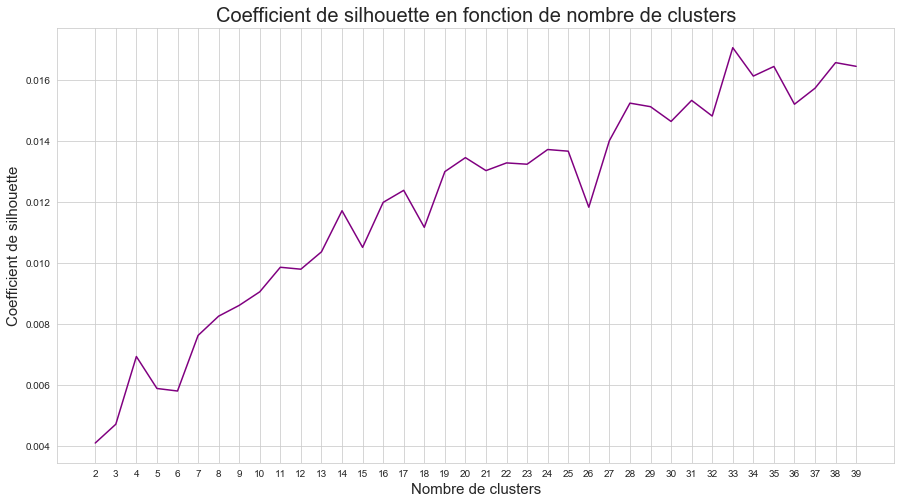

In [72]:
def choose_num_k(data, num_max):
    """Function which helps to choose an optimal number of clusters for MiniBatchKmeans algorithme.abs
    
    Inputs:
    - data : an array of data to be clusteres
    - num_max : a maximal number of clusters
    
    Output:
    - a plot of silhouette coefficient depending on number of clusters 
    
    """
    silhouette = []
    k = list(range(2, num_max))
    
    # Fit the model
    for i in k:
        kmeans = MiniBatchKMeans(n_clusters=i, init_size=1024, batch_size=2048, random_state=20)
        y_pred = kmeans.fit_predict(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette.append(score)
        
    # Plot the silhouette coefficient        
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Nombre de clusters', fontsize=15)
    ax.set_xticks(k)
    ax.set_xticklabels(k)
    ax.set_ylabel('Coefficient de silhouette', fontsize=15)
    ax.set_title('Coefficient de silhouette en fonction de nombre de clusters', fontsize=20)


    plt.plot(k, silhouette, color="purple")
    

choose_num_k(X_train_tfidf, 40)    

Nous allons choisir 14 clusters.

#### Créer le modèle

In [73]:
def predict_MiniBatchKMeans(data,k):
    """Function which returns a vector of k predicted clusters using MiniBatchKMeans algorithm.
    
    INPUTS:
    - data : en array of data to be clustered
    - k : number of clusters
    
    OUTPUT:
    - a vector of k predicted clusters    
    """
    # Fit the model
    kmeans = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
    
    # Predict clusters
    y_pred = kmeans.fit_predict(data)
    return y_pred
    
clusters = predict_MiniBatchKMeans(X_train_tfidf,14)   

#### Visualisation de clusters

In [74]:
def plot_clusters(X, clusters, k, model='PCA'):
    """Function to plot a 2D scatter plot of clusters. The dimensionnality reduction is done either by PCA
    or by t-SNE
    
    INPUTS:
    - X : array of data 
    - clusters : a vector of clusters (max = 14)
    - k : number of clusters
    - model : 'PCA' (default) or 'TSNE'
    
    OUTPUT:
    - a scatterplot of k clusters   
     
    
    """
    
    # Define the color's vector
    colors = ['salmon', 'khaki', 'darkviolet', 'black', 'blue', 'green', 'indigo', 
              'yellow', 'red', 'violet', 'c', 'darkslategrey', 'orange', 'olive']
    
    # Define the title
    mean_title = str('Title k-means clusters in ' + model + ' representation')
    
    # Format the cluster's vector
    y_pred_df = DataFrame(clusters)
    y_pred_df.rename({0: 'Cluster'}, axis=1, inplace=True)
    
    # Define the model
    if model=='PCA':
        mod = PCA(n_components=2)
    else:
        mod = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
        
    # Fit the model
    principalComponents = mod.fit_transform(X)
    
    # Create the DataFrame of principal components + clusters
    principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'principal component 1', 'principal component 2'])
    principalDf = principalDf.merge(y_pred_df, left_index=True, right_index=True)
    
    # Plot the figure    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize=10)
    ax.set_ylabel('Principal Component 2', fontsize=10)
    ax.set_title(mean_title, fontsize=12)

    targets = list(range(k))
    for target, color in zip(targets, colors[:k]):
        indicesToKeep = principalDf['Cluster'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
               principalDf.loc[indicesToKeep, 'principal component 2'], c=color, s=50, alpha=0.5)
    ax.legend(targets)
    ax.grid()
    

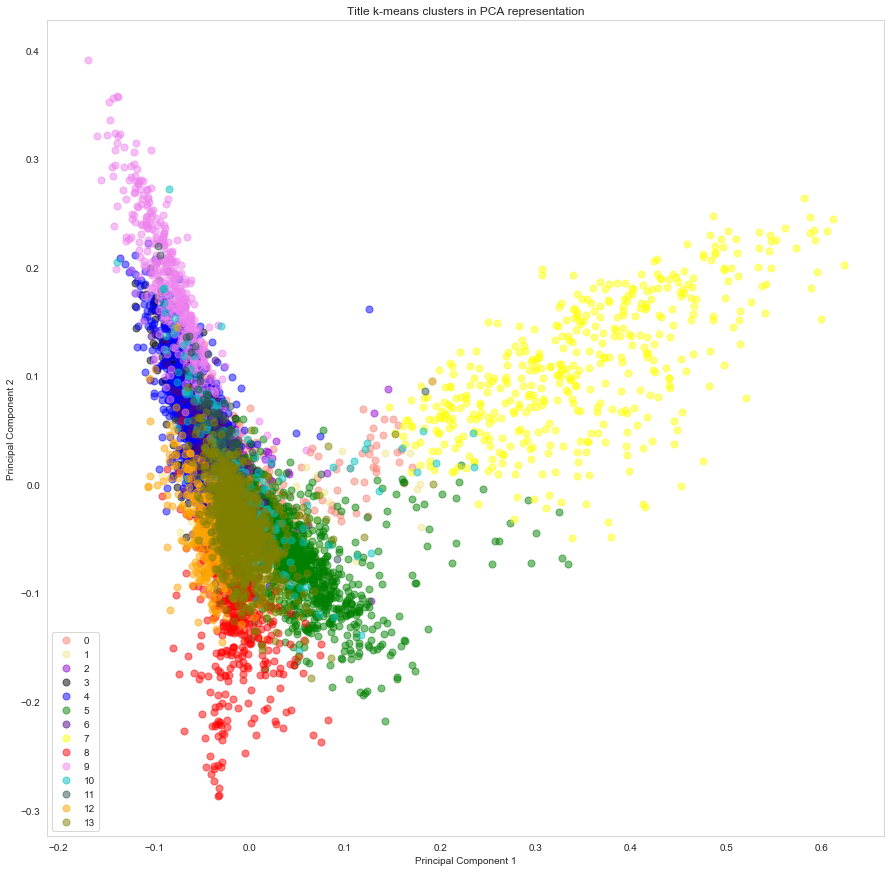

In [75]:
plot_clusters(X_train_tfidf, clusters, 14)

t-SNE

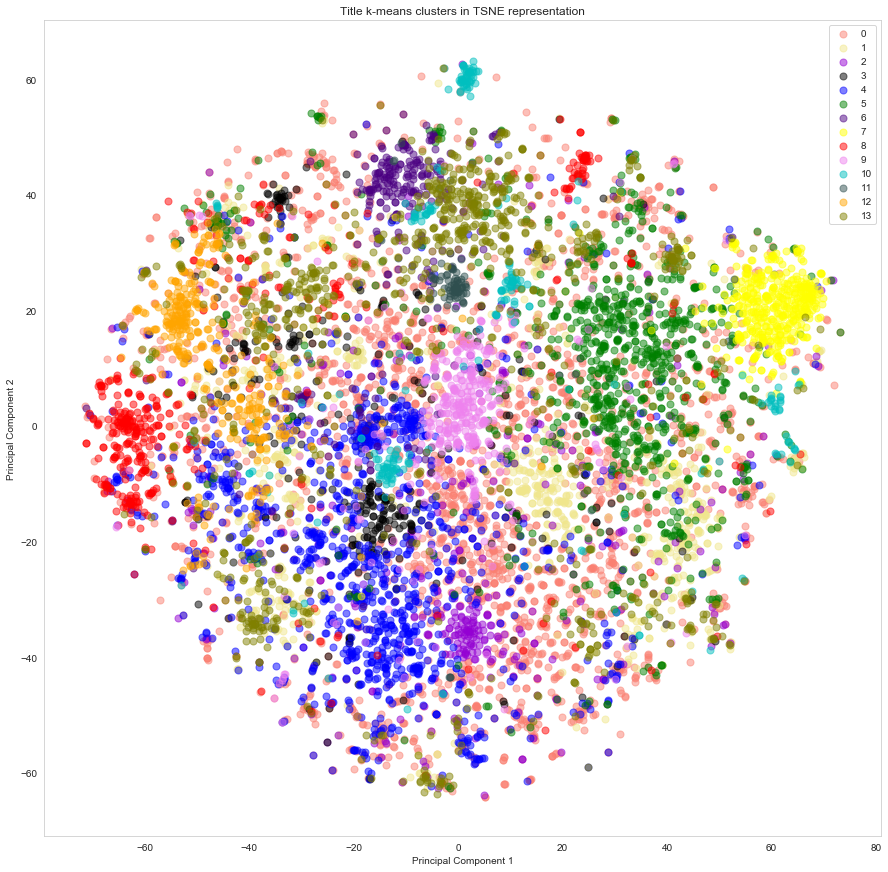

In [76]:
plot_clusters(X_train_tfidf, clusters, 14, model='TSNE')

#### Description de clusters

In [79]:
def print_top_words(k, vocabulary, distances, clusters):
    """Funtion which returns 10 top words for each cluster.abs
    
    INPUTS :
    - k : number of clusters
    - vocabulary : a list of vocabulary
    - distances : a list of distances
    - clusters : a vector of clusters
    
    OUTPUT :
    - print a list of 10 most frequent words for each cluster
    
    """
    
    top_words = DataFrame(zip(vocabulary, distances, clusters), 
                      columns=['word', 'dist', 'cluster'])
    for i in range(k):
        temp = top_words[top_words['cluster']==i]
        temp = temp.sort_values(['dist'], ascending=False)[:10]
        print("Cluster" + str(i) + ": ") 
        print(list(temp['word']))
        print('\n')
        
print_top_words(14, X_train_vocab_tfidf, X_train_dist_tfidf, clusters)

Cluster0: 
['get', 'code', 'difference', 'class', 'python', 'java', 'user', 'c', 'error', 'image']


Cluster1: 
['type', 'array', 'key', 'web', 'content', 'r', 'mysql', 'item', 'output', 'start']


Cluster2: 
['application', 'com', 'module', 'build', 'edit', 'linux', 'always', 'count', 'byte', 'py']


Cluster3: 
['name', 'time', 'table', 'version', 'size', 'password', 'specific', 'github', 'style', 'activity']


Cluster4: 
['like', 'function', 'android', 'app', 'set', 'div', 'j', 'net', 'case', 'sql']


Cluster5: 
['file', 'object', 'return', 'project', 'script', 'variable', 'int', 'public', 'library', 'request']


Cluster6: 
['list', 'column', 'result', 'write', 'install', 'folder', 'g', 'ruby', 'given', 'space']


Cluster7: 
['event', 'update', 'f', 'tag', 'programming', 'width', 'screen', 'visual', 'action', 'us']


Cluster8: 
['server', 'command', 'someone', 'best-way', 'location', 'false', 'expression', 'mvc', 'empty', 'node-j']


Cluster9: 
['string', 'git', 'mean', 'input', 'lan

### Feature = titre

#### Choisir le nombre de clusters

Dans un premier temps, nous allons étudier le nombre de clusters optimal à l'aide de **coefficient de silhouette**.

In [ ]:
choose_num_k(X_train_title_tfidf, 40) 

Le coefficient de silhouette augmente avec le nombre de clusters. Il faudra faire un compromis entre le nombre de cluster raisonnable et la qualité de clusters. Nous allons choisir 14 clusters qui avec le coefficient de silhouette de 0.017 environ.

#### Créer le modèle

Nous allons choisir 14 clusters :

In [ ]:
clusters = predict_MiniBatchKMeans(X_train_title_tfidf,14)   

#### Visualisation de clusters

Tout d'abord, nous allons visualiser les données avec l'ACP :

In [ ]:
plot_clusters(X_train_title_tfidf, clusters, 14)

In [ ]:
plot_clusters(X_train_title_tfidf, clusters, 14, model='TSNE')

#### Description de clusters

In [ ]:
print_top_words(14, X_train_title_vocab_tfidf, X_train_title_dist_tfidf, y_pred)

### Feature = tags

#### Choisir le nombre de clusters

Dans un premier temps, nous allons étudier le nombre de clusters optimal à l'aide de **coefficient de silhouette**.

In [ ]:
choose_num_k(y_train_tfidf, 40) 

#### Créer le modèle

Nous allons choisir 12 clusters :

In [ ]:
clusters = predict_MiniBatchKMeans(y_train_tfidf,12)   

#### Visualisation de clusters

Tout d'abord, nous allons visualiser les données avec l'ACP :

In [ ]:
plot_clusters(y_train_tfidf, clusters, 12)

Le second graphique sera fait avec t-SNE:

In [ ]:
plot_clusters(y_train_tfidf, clusters, 12, model='TSNE')

#### Description de clusters

In [ ]:
print_top_words(12, y_train_vocab_tfidf, y_train_dist_tfidf, y_pred)

# Modélisation supervisée

## KNN + word2vect

In [ ]:
# !!! A tester
# model = Word2Vec.load("300features_40minwords_10context")